In [1]:
import os, sys, numpy as np, glob, matplotlib, scipy, healpy
%matplotlib inline
from matplotlib import pyplot
from scipy import interpolate, misc

In [25]:
filedict = {'numu': glob.glob("./output/numu/*[0-9]_maps.npy"),
            'nutau': glob.glob("./output/nutau/*[0-9]_maps.npy"),
            'nue': glob.glob("./output/nue/*[0-9]_maps.npy"),
            'data': glob.glob("./output/data/*[0-9]_maps.npy"),
           }

# These must be in the same order that we produced the neutrinos
# rec array file in!
neutrino_maps_files = filedict['numu'] + filedict['nue'] + filedict['nutau']
data_maps_files = filedict['data']

neutrinos = np.load('./IC86_2018_MC.npy')
data = np.load("IC86_2012-2018_Data.npy")


In [26]:
class map_stream:
    fnames = []
    findex = 0
    index = 0
    current = None

    def __init__(self, filenames):
        self.fnames = sorted(filenames)
        self.index = 0
        self.findex = 0
        self.current = np.load(self.fnames[self.findex])
        
    def next(self):
        event = None
        if self.index >= len(self.current):
            #print 'Loading next file:', 
            self.findex += 1
            self.index = 0
            if self.findex >= len(self.fnames):
                #print("No more files or events to load.")
                return None
            #print self.fnames[self.findex]
            self.current = np.load(self.fnames[self.findex])
        event = self.current[self.index]
        self.index += 1
        return np.copy(event)
    
    def reset(self):
        self.index = 0
        self.findex = 0
        self.current = np.load(self.fnames[self.findex])
        
    def more(self):
        if len(self.current) > self.index:
            return True
        if len(self.fnames) > self.findex:
            return True
        return False

    
neutrino_maps = map_stream(neutrino_maps_files)
data_maps = map_stream(data_maps_files)

In [27]:
# calculate the median for each
def get_percentiles(x, y, weights, bins, percentile=0.68):
    output = np.zeros_like(ebins[:-1])

    for i in range(ebins.shape[0]-1):
        emin, emax = ebins[i], ebins[i+1]
        mask = (x>=emin) & (x<emax)
        if mask.sum()==0: continue

        # Make a cumulative plot
        h, b = np.histogram(y[mask], weights=weights[mask], bins=1000)
        h = np.cumsum(h)/np.sum(h)
        
        # Find the right percentile
        j = np.searchsorted(h, percentile,)-1
        output[i] = b[j]

    return output

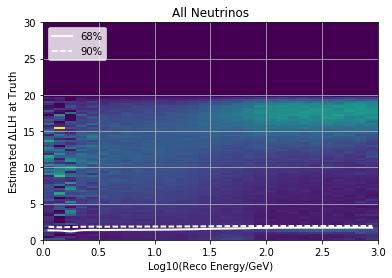

In [59]:
ebins = np.linspace(0, 3, 31)

dllh = neutrinos['trueDeltaLLH']
neutrinos['trueDeltaLLH'][dllh > 1000] = 1000

fig, ax = pyplot.subplots()
w = 800*neutrinos['ow'] * neutrinos['trueE']**-3.7
h, xedges, yedges = np.histogram2d(neutrinos['logE'],
                                  neutrinos['trueDeltaLLH'],
                                  bins = (ebins,
                                          np.linspace(0, 30, 101)),
                                  weights = w)

# Normalize along each column
for i in range(h.shape[0]):
    h[i] /= np.sum(h[i])
ax.pcolormesh(xedges, yedges, h.T)

pull_ebins = np.linspace(0, 4, 21)
one_sigma_pulls = get_percentiles(neutrinos['logE'],
                                  neutrinos['trueDeltaLLH'] / 10, 
                                  w, pull_ebins, 
                                  percentile=0.68)
one_sigma_pulls[one_sigma_pulls > yedges.max()] = yedges.max()
ax.plot(ebins[:-1]+np.diff(ebins)/2.0,
        one_sigma_pulls,
       color = 'w', linewidth=2,
       label = '68%')

two_sigma_pulls = get_percentiles(neutrinos['logE'],
                                  neutrinos['trueDeltaLLH'] / 10, 
                                  w, pull_ebins, 
                                  percentile=0.95)
two_sigma_pulls[two_sigma_pulls > yedges.max()] = yedges.max()
ax.plot(ebins[:-1]+np.diff(ebins)/2.0,
        two_sigma_pulls,
        color = 'w', linewidth=2,
        linestyle = 'dashed',
        label = '90%')

ax.grid()
ax.legend(loc='upper left')
ax.set_xlabel("Log10(Reco Energy/GeV)")
ax.set_ylabel(r'Estimated $\Delta$LLH at Truth')
ax.set_title('All Neutrinos')

(30,)
(30,)
1.3042150584793921 1.6717306509146017


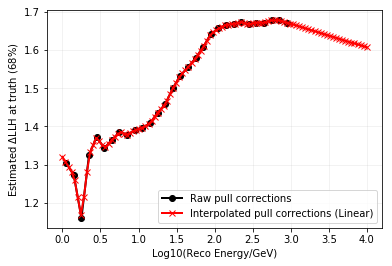

In [60]:
# Parametrize the 1 sigma pulls
from scipy.interpolate import interp1d

print (ebins[:-1]+np.diff(ebins)/2.0).shape
print one_sigma_pulls.shape

spline = interp1d(ebins[:-1]+np.diff(ebins)/2.0,
                 one_sigma_pulls,
                  kind = 'linear',
                  fill_value = 'extrapolate')#(one_sigma_pulls[0],
                                #one_sigma_pulls[-1]))
print one_sigma_pulls[0], one_sigma_pulls[-1]

fig, ax = pyplot.subplots()
ax.plot(ebins[:-1]+np.diff(ebins)/2.0,
        one_sigma_pulls,
        color = 'k',
        marker = 'o',
        linewidth = 2,
        label = 'Raw pull corrections')

x = np.linspace(0, 4, 100)
y = spline(x)
ax.plot(x, y,
        color = 'r',
        marker = 'x',
        linewidth = 2,
        label = 'Interpolated pull corrections (Linear)')

ax.legend(loc='lower right')
ax.grid(alpha=0.2)
ax.set_xlabel("Log10(Reco Energy/GeV)")
ax.set_ylabel(r'Estimated $\Delta$LLH at truth (68%)')


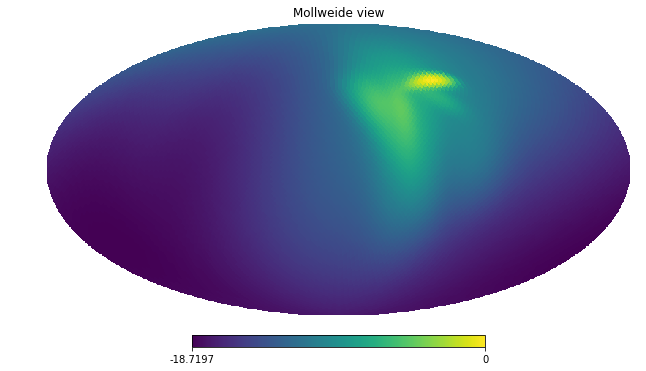

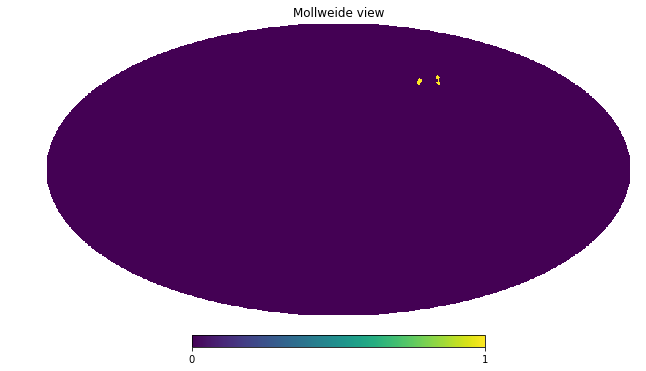

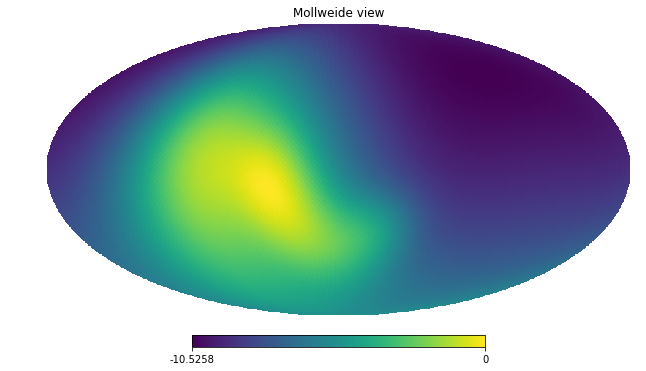

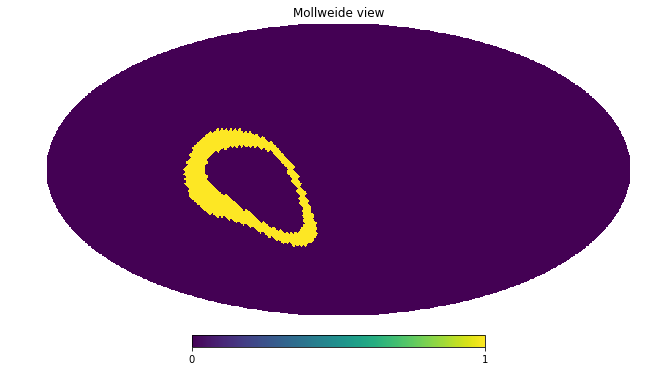

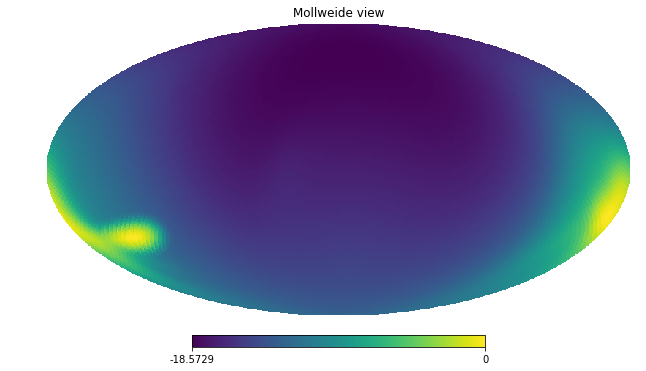

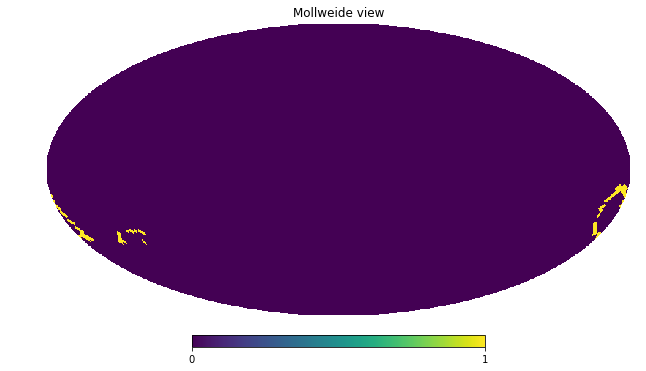

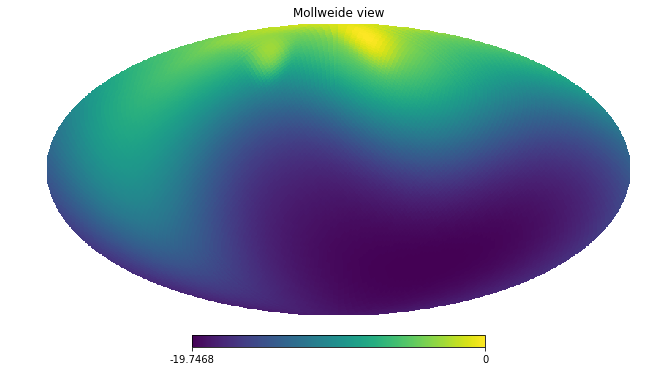

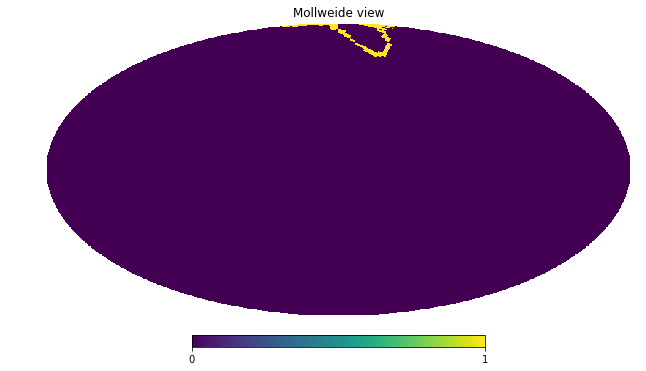

In [61]:
# Start applying this to each map?
neutrino_maps.reset()
event_index = 0
while neutrino_maps.more():
    if event_index+1 >= neutrinos.shape[0]: break
    m = neutrino_maps.next()
    energy = neutrinos[event_index]['logE']
    
    # scale it so its "normalized"
    m = np.min(m)-m
    
    # find the points with this 
    dllh_1sigma = -1*spline(energy)

    # Find the points with a llh like this?
    inside = np.ones_like(m, dtype=bool)
    inside &= (m > dllh_1sigma-0.3)
    inside &= (m < dllh_1sigma+0.3)

    healpy.mollview(m)
    healpy.mollview(inside)
    
    if inside.sum() == 0:
        neutrinos[event_index]['angErr'] = np.pi
        continue
    
    # Find the average angular distance from
    # the peak to each point
    indicies = np.arange(len(m))[inside]
    peak = np.argmax(m)
    
    nside = healpy.npix2nside(len(m))
    peak_xyz = healpy.pix2vec(nside, peak)
    band = healpy.pix2vec(nside, indicies)

    dist = healpy.rotator.angdist(peak_xyz, band)
    neutrinos[event_index]['angErr'] = np.mean(dist)
    
    event_index += 1
    if event_index > 3: break
    

In [62]:
def set_circularized_err(events, maps):
    maps.reset()
    event_index = 0
    while maps.more():
        if (event_index % 1000) == 0: print event_index, 
            
            
        if event_index >= events.shape[0]: break
            
        m = maps.next()
        energy = events[event_index]['logE']

        # scale it so its "normalized"
        m = np.min(m)-m

        # find the points with this dllh
        dllh_1sigma = -1*spline(energy)
        inside = np.ones_like(m, dtype=bool)
        inside &= (m > dllh_1sigma-0.1)
        inside &= (m < dllh_1sigma+0.1)

        if inside.sum() == 0:
            events[event_index]['angErr'] = np.pi
            event_index += 1
            continue

        # Find the average angular distance from
        # the peak to each point
        indicies = np.arange(len(m))[inside]
        peak = np.argmax(m)

        nside = healpy.npix2nside(len(m))
        peak_xyz = healpy.pix2vec(nside, peak)
        band = healpy.pix2vec(nside, indicies)

        dist = healpy.rotator.angdist(peak_xyz, band)
        events[event_index]['angErr'] = np.mean(dist)

        event_index += 1
    
    return



In [ ]:
# Save the updated values for signal

print neutrinos.shape
#neutrinos = neutrinos[:100]
#neutrino_maps = neutrino_maps[:100]

set_circularized_err(neutrinos[:200000], neutrino_maps)
#np.save(open('./IC86_2018_MC.npy', 'w'), neutrinos)

(1471875,)
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000

In [47]:
# Save the updated values for data
set_circularized_err(data, data_maps)
np.save(open("IC86_2012-2018_Data.npy", 'w'), data)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000

KeyboardInterrupt: 

/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in divide


ValueError: range parameter must be finite.

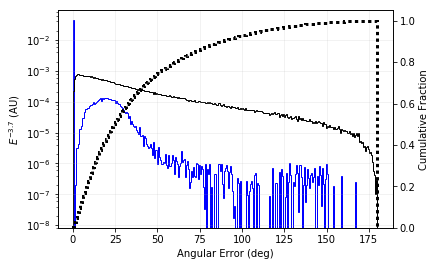

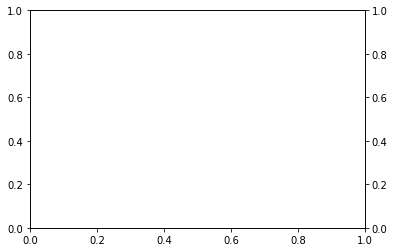

In [67]:
true_dist = healpy.rotator.angdist([np.rad2deg(neutrinos['ra']), 
                                    np.rad2deg(neutrinos['dec'])],
                                   [np.rad2deg(neutrinos['trueRa']), 
                                    np.rad2deg(neutrinos['trueDec'])],
                                   lonlat = True
                                  )
ang_err = np.copy(neutrinos['angErr'])

fig, ax = pyplot.subplots()
ax2 = ax.twinx()

w = neutrinos['ow'] * neutrinos['trueE']**-3.7
w /= np.sum(w)

mask = np.ones_like(neutrinos['ow'], dtype=bool)
mask &= neutrinos['trueE'] > 100
mask &= neutrinos['angErr'] < np.pi
mask &= w < np.inf

h, b, j = ax.hist(np.rad2deg(ang_err)[mask], 
                  weights=w[mask], 
                  bins=np.linspace(0, 180, 300),
                  histtype='step', color='b')

# Cumulative line
'''
h = np.cumsum(h) / np.sum(h)
ax2.hist(b[:-1], bins=b, weights=h, 
        linewidth = 3, 
        histtype='step',
        linestyle = 'dashed',
        color = 'b',
        label = 'Cumulative Fraction')
'''


h, b, j = ax.hist(np.rad2deg(true_dist)[mask], 
                  weights=w[mask], 
                  bins=np.linspace(0, 180, 300),
                  histtype='step', color='k')
h = np.cumsum(h) / np.sum(h)
ax2.hist(b[:-1], bins=b, weights=h, 
        linewidth = 3, 
        histtype='step',
        linestyle = 'dotted',
        color = 'k',
        label = 'Cumulative Fraction')



ax.grid(alpha=0.2)
ax.set_yscale('log')
ax.set_xlabel("Angular Error (deg)")
ax.set_ylabel(r'$E^{-3.7}$ (AU)')
ax2.set_ylabel("Cumulative Fraction", color='k')






fig, ax = pyplot.subplots()
ax2 = ax.twinx()

h, b, j = ax.hist(true_dist[mask] / ang_err[mask], 
                  weights=w[mask], 
                  bins=np.linspace(0, 10, 200),
                  histtype='step',
                  linewidth = 2, 
                 linestyle = 'solid',
                  label = 'Events'
                 )

# Cumulative line
'''
h = np.cumsum(h) / np.sum(h)
ax2.hist(b[:-1], bins=b, weights=h, 
        linewidth = 3, 
        histtype='step',
        linestyle = 'dashed',
        color = 'r',
        label = 'Cumulative Fraction')

ax.hist([-1], bins=b, weights=[0], 
        linewidth = 3, 
        histtype='step',
        linestyle = 'dashed',
        color = 'r',
        label = 'Cumulative Fraction')
'''


ax.legend(loc='lower right')
ax.grid(alpha=0.2)
ax.set_ylim(0, 0.1)
ax2.set_ylim(0, 1)
ax.set_xlim(0, 5)
ax.set_xlabel(r'$\left|Reco-Truth\right|$ / $\sigma$ (Pull-Corrected)')
ax.set_ylabel(r'$E^{-3.7}$ Weight (AU)')
ax2.set_ylabel("Cumulative Fraction", color='r')



/cvmfs/icecube.opensciencegrid.org/py2-v3.1.1/RHEL_7_x86_64/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in divide


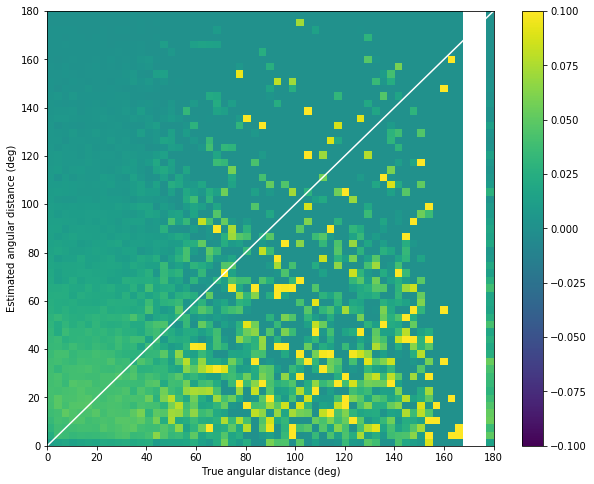

In [68]:
fig, ax = pyplot.subplots(figsize=(10, 8))

true_dist = healpy.rotator.angdist([np.rad2deg(neutrinos['ra']), 
                                    np.rad2deg(neutrinos['dec'])],
                                   [np.rad2deg(neutrinos['trueRa']), 
                                    np.rad2deg(neutrinos['trueDec'])],
                                   lonlat = True
                                  )
ang_err = np.copy(neutrinos['angErr'])

h, xedges, yedges = np.histogram2d(np.rad2deg(true_dist), 
                                   np.rad2deg(ang_err),
                                   weights = w,
                                   bins = (np.linspace(0, 180, 60),
                                           np.linspace(0, 180, 60)))
for i in range(h.shape[1]):
    h[:,i] /= np.sum(h[:,i])
    
mesh = ax.pcolormesh(xedges, yedges, h)
pyplot.colorbar(mesh)
ax.plot([0, 180], [0, 180], color='w',)
ax.set_xlabel("True angular distance (deg)")
ax.set_ylabel("Estimated angular distance (deg)")


In [ ]:
# Mia-like splined angular uncertainties
